## **Practical No: 3**

### **AIM:** Create SOM for Text Clustering based on the Retail Transactions.

### **CODE and OUTPUT**

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
retail = pd.read_csv('/content/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
retail.shape

(541909, 8)

In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [8]:
retail = retail.dropna()
retail.shape

(406829, 8)

In [9]:
retail['CustomerID'] = retail['CustomerID'].astype(str)

In [10]:
#We are going to analysis the Customers based on below 3 factors:
#R (Recency): Number of days since last purchase
#F (Frequency): Number of tracsactions
#M (Monetary): Total amount of transactions (revenue contributed)

In [11]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [12]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [13]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [14]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [15]:
 #Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [16]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [17]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [18]:
# Extract number of days only
rfm_p['Diff'] = rfm_p['Diff'].dt.days
#def number_of_days_in_month(year=2019, month=2):
 #   return monthrange(year, month)[1]
#rfm_p['Diff'] = rfm_p['Diff'].datetime.day
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [19]:
# Merge tha dataframes to get the final RFM dataframe
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [20]:
#There are 2 types of outliers and we will treat outliers as it can skew our dataset
#Statistical
#Domain specific

Text(0.5, 0, 'Attributes')

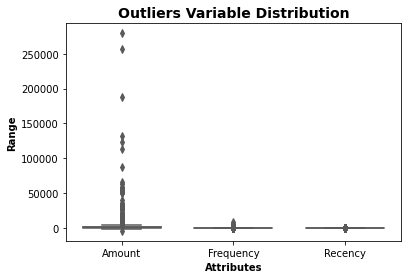

In [21]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [6,4]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [22]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [23]:
#Rescaling the Attributes
#It is extremely important to rescale the variables so that they have a comparable scale.| 
#There are two common ways of rescaling:

#Min-Max scaling
#Standardisation (mean-0, sigma-1)
#Here, we will use Standardisation Scaling.

In [24]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [25]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [26]:
features = rfm_df_scaled[['Amount', 'Frequency','Recency']]

# Transform features to list
data = features.values
data.shape

(4293, 3)

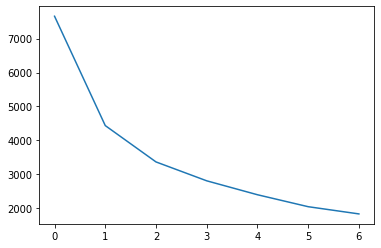

In [27]:
#SOM
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [28]:
# I use linear som topography
som_shape = (1, 3)

In [29]:
!pip install minisom
from minisom import MiniSom  

import matplotlib.pyplot as plt
%matplotlib inline


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=8de06230e6e05f023593991f1e7e960d49792c88d6dfcae3674b95820cc0d5bd
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom


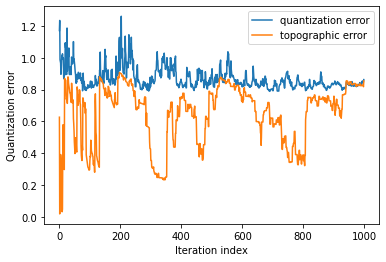

In [30]:
# I use linear som topography
#som_shape = (1, 5)
som_shape = (1, 3)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=0.5, learning_rate=0.5)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('Quantization error')
plt.xlabel('Iteration index')
plt.legend()
plt.show()



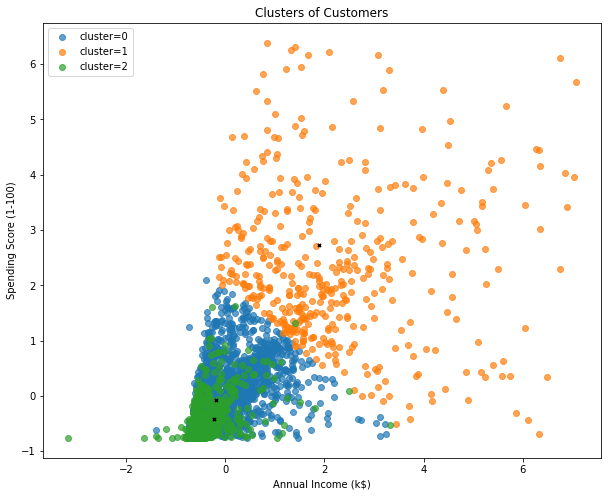

In [31]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T

# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotting the clusters 
plt.figure(figsize=(10,8))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# Plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=10, linewidths=20, color='k') # label='centroid'
    
plt.title("Clusters of Customers")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend();

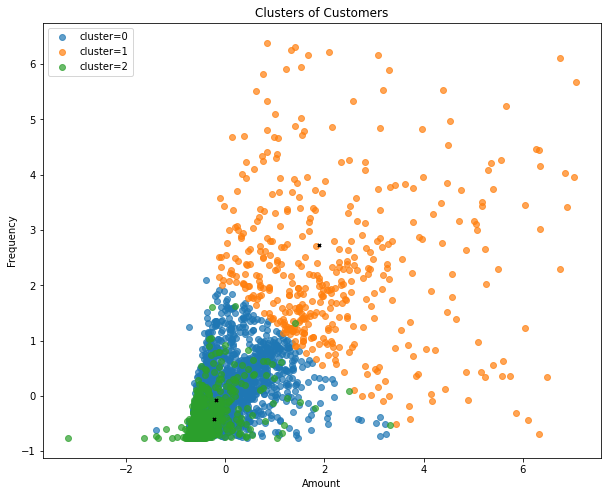

In [32]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T

# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotting the clusters 
plt.figure(figsize=(10,8))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# Plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=10, linewidths=20, color='k') # label='centroid'
    
plt.title("Clusters of Customers")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.legend();

In [33]:
# Comparison of SOM with other machine learning clustering algorithms
#A list of 10 of the more popular algorithms is as follows:

#Affinity Propagation
#Agglomerative Clustering
#BIRCH
#DBSCAN
#K-Means
#Mini-Batch K-Means
#Mean Shift
#OPTICS
#Spectral Clustering
#Mixture of Gaussians


In [34]:
# birch clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import Birch
from matplotlib import pyplot
# define dataset
###X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = Birch(threshold=0.01, n_clusters=3)
# fit the model
###model.fit(X)
y= model.fit(rfm_df_scaled)

# assign a cluster to each example
yhat = model.predict(rfm_df_scaled)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster


In [40]:
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)

In [41]:
row_ix

(array([   0,    4,    6,    7,    8,   14,   18,   23,   26,   33,   43,
          44,   51,   54,   63,   76,   81,  112,  121,  123,  125,  126,
         129,  133,  134,  160,  163,  169,  171,  173,  174,  180,  181,
         186,  188,  197,  206,  210,  217,  225,  226,  238,  250,  251,
         261,  262,  267,  278,  281,  293,  310,  315,  316,  317,  318,
         319,  320,  337,  339,  352,  353,  354,  355,  358,  360,  363,
         368,  371,  378,  380,  383,  393,  397,  400,  406,  409,  411,
         412,  418,  424,  426,  429,  430,  458,  460,  469,  479,  480,
         484,  488,  496,  499,  504,  505,  521,  527,  528,  535,  538,
         539,  541,  543,  548,  549,  554,  566,  572,  580,  581,  588,
         589,  599,  613,  616,  630,  632,  650,  654,  655,  658,  659,
         661,  665,  668,  684,  685,  691,  702,  707,  711,  715,  735,
         744,  747,  757,  758,  765,  766,  767,  774,  776,  780,  782,
         785,  811,  818,  825,  833, 

In [42]:
y

Birch(threshold=0.01)

In [43]:
yhat

array([2, 0, 1, ..., 2, 1, 1])

In [44]:
#plt.scatter(rfm_df_scaled[row_ix, 0],rfm_df_scaled[row_ix, 1])
rfm_df_scaled


,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188
...,...,...,...
4288,-0.624669,-0.683068,-0.193560
4289,-0.620853,-0.673094,1.826341
4290,-0.677696,-0.703017,0.865898
4291,-0.623131,-0.643171,-0.847057


In [45]:
row_ix

(array([   0,    4,    6,    7,    8,   14,   18,   23,   26,   33,   43,
          44,   51,   54,   63,   76,   81,  112,  121,  123,  125,  126,
         129,  133,  134,  160,  163,  169,  171,  173,  174,  180,  181,
         186,  188,  197,  206,  210,  217,  225,  226,  238,  250,  251,
         261,  262,  267,  278,  281,  293,  310,  315,  316,  317,  318,
         319,  320,  337,  339,  352,  353,  354,  355,  358,  360,  363,
         368,  371,  378,  380,  383,  393,  397,  400,  406,  409,  411,
         412,  418,  424,  426,  429,  430,  458,  460,  469,  479,  480,
         484,  488,  496,  499,  504,  505,  521,  527,  528,  535,  538,
         539,  541,  543,  548,  549,  554,  566,  572,  580,  581,  588,
         589,  599,  613,  616,  630,  632,  650,  654,  655,  658,  659,
         661,  665,  668,  684,  685,  691,  702,  707,  711,  715,  735,
         744,  747,  757,  758,  765,  766,  767,  774,  776,  780,  782,
         785,  811,  818,  825,  833, 